# LSTM Tutorial for time series prediction
Based on http://dacatay.com/data-science/part-6-time-series-prediction-neural-networks-python/

In [1]:
import pandas as pd
import numpy as np
import pdb
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
# set seed
np.random.seed(7)
 
# import data set
df = pd.read_csv('passengers.csv', sep=';', parse_dates=True, index_col=0)
data = df.values
 
# using keras often requires the data type float32
data = data.astype('float32')
 
# slice the data
train = data[0:120, :]   # length 120
test = data[120:, :]     # length 24

The prepare_data function transforms the time series into a regression problem

In [3]:
def prepare_data(data, lags=1):
    """
    Create lagged data from an input time series
    """
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags), 0]
        X.append(a)
        y.append(data[row + lags, 0])
    return np.array(X), np.array(y)
 
# prepare the data
lags = 1 # this variable is how many time steps to take as the input
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
y_true = y_test     # due to naming convention

print(X_train[0:4],y_train[0:4])

[[112.]
 [118.]
 [132.]
 [129.]] [118. 132. 129. 121.]


## Fit data with small ANN

In [4]:
mdl = Sequential()
mdl.add(Dense(3, input_dim=lags, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=200, batch_size=2, verbose=0)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
# estimate model performance
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, np.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, np.sqrt(test_score)))

Train Score: 816.70 MSE (28.58 RMSE)
Test Score: 2800.48 MSE (52.92 RMSE)


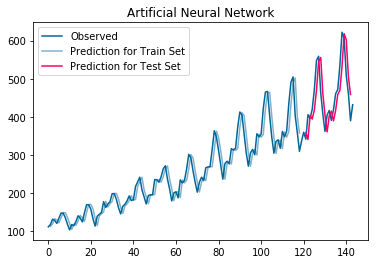

In [6]:
# generate predictions for training
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)
 
# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags*2)+1:len(data)-1, :] = test_predict
 
# plot baseline and predictions
plt.plot(data, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for Train Set', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for Test Set', color='#ff0066');
plt.legend(loc='best');
plt.title('Artificial Neural Network')
plt.show()

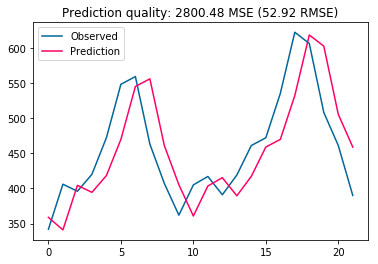

In [7]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, np.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed', color='#006699')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='#ff0066')
plt.legend(loc='best');
plt.show()

All that this network did was "predict" the next point as equal to the current point. We can improve this by giving it more information about the past.

## Take more time steps as input and try ANN again

In [8]:
# reshape and lag shift the dataset
lags = 3
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)

print(X_train.shape)
print(y_train.shape)

(116, 3)
(116,)


Train Score: 707.43 MSE (26.60 RMSE)
Test Score: 2144.64 MSE (46.31 RMSE)


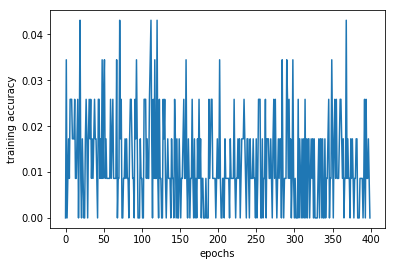

In [9]:
mdl = Sequential()
mdl.add(Dense(20, input_dim=lags, activation='relu'))
mdl.add(Dense(10, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam', metrics = ['accuracy'])
history = mdl.fit(X_train, y_train, epochs=400, batch_size=2, verbose=0)

plt.plot(history.history['acc'])
plt.xlabel('epochs')
plt.ylabel('training accuracy')
    
# Estimate model performance
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score[0], np.sqrt(train_score[0])))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score[0], np.sqrt(test_score[0])))

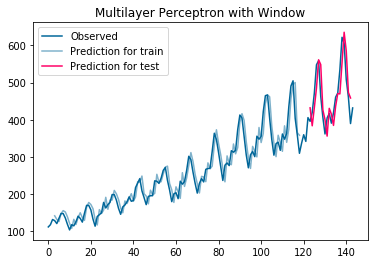

In [10]:
# generate predictions for training
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)
 
# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags * 2)+1:len(data)-1, :] = test_predict
 
# plot observation and predictions
plt.plot(data, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for train', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for test', color='#ff0066');
plt.legend(loc='best')
plt.title('Multilayer Perceptron with Window')
plt.show()

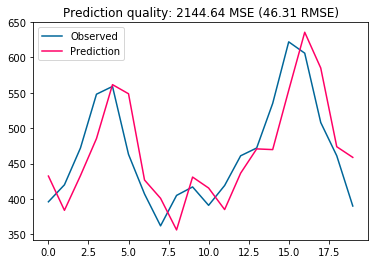

In [11]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, np.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed', color='#006699')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='#ff0066')
plt.legend(loc='upper left');
plt.show()

That's better! Let's see if LSTM can improve.

## LSTM

(116, 1, 3)
(116,)
(18, 1, 3)


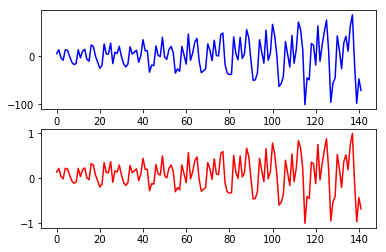

In [12]:
# fix random seed for reproducibility
np.random.seed(1)
 
# load the dataset
df = pd.read_csv('passengers.csv', sep=';', parse_dates=True, index_col=0)
data = df.values
data = data.astype('float32')

# Difference function to make stationary
def difference(ds, interval=1):
    diff = list()
    for i in range(interval, len(ds)-1):
        value = ds[i] - ds[i - interval]
        diff.append(value)
    return np.asarray(diff)


# Make dataset stationary and plot
dataset = difference(data, 1)
plt.subplot(2,1,1)
plt.plot(dataset,color='blue')

# normalize the dataset and plot
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
plt.subplot(2,1,2)
plt.plot(dataset,color='red')
 
# split into train and test sets
train = dataset[0:120, :]
test = dataset[120:, :]
 
# reshape into X=t and Y=t+1
lags = 3
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
 
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)

In [13]:
# create and fit the LSTM network
mdl = Sequential()
mdl.add(Dense(3, input_shape=(1, lags), activation='relu'))
mdl.add(LSTM(6, activation='relu'))
mdl.add(Dense(1, activation='relu'))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [14]:
# make predictions
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

# invert transformation
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
 

# calculate root mean squared error
train_score = np.sqrt(np.mean((y_train[0] - train_predict[:,0])**2))
print('Train Score: {:.2f} RMSE'.format(train_score))
test_score = np.sqrt(np.mean((y_test[0] - test_predict[:,0])**2))
print('Test Score: {:.2f} RMSE'.format(test_score))

Train Score: 25.13 RMSE
Test Score: 46.37 RMSE


In [16]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags:len(train_predict)+lags, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (lags * 2)+1:len(data)-1, :] = test_predict
 
# plot observation and predictions
plt.plot(data, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for Train Set', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for Test Set', color='#ff0066');
plt.legend(loc='upper left')
plt.title('LSTM Recurrent Neural Net')
plt.show()

ValueError: could not broadcast input array from shape (18,1) into shape (20,1)

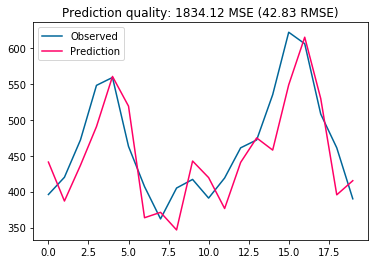

In [19]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, np.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed', color='#006699')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='#ff0066')
plt.legend(loc='upper left');
plt.show()